In [20]:
%load_ext autoreload
%autoreload 2
import os
import pathlib

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
# os.environ["BART_TOOLBOX_PATH"] = "/Users/chunxuguo/bart"

import torch
import torchopt
from einops import rearrange, reduce
from fastmri import complex_abs
from fastmri.data import mri_data, subsample, transforms

from ese5934_project.datasets.csm_estimation import espirit_csm_estimation
from ese5934_project.models.operators import ForwardModel, MaskedForwardModel
from ese5934_project.tasks.mri_reconstruction_2d import reconstruct

# Create a mask function
mask_func = subsample.RandomMaskFunc(center_fractions=[0.08], accelerations=[4])


def data_transform(kspace, mask, target, data_attributes, filename, slice_num):
    # Transform the data into appropriate format
    # Here we simply mask the k-space and return the result
    kspace = transforms.to_tensor(kspace * 1e5)
    mean = reduce(kspace, "ch h w complex-> () () complex", "mean")
    std = reduce(kspace, "ch h w complex-> () () complex", torch.std)
    print(mean, std)
    print(mean.shape, std.shape)
    masked_kspace, mask, num_low_frequencies = transforms.apply_mask(kspace, mask_func)
    csm = transforms.to_tensor(espirit_csm_estimation(kspace, num_low_frequencies))
    # kspace = kspace
    # masked_kspace = masked_kspace
    # csm = csm
    # mask = rearrange(mask, "() () w ()-> () () w")
    csm = rearrange(csm, "() h w ch complex-> ch h w complex")
    return kspace, (mean, std), masked_kspace, mask, csm


dataset = mri_data.SliceDataset(
    root=pathlib.Path("/bmrc-an-data/Chunxu/ese5934_project/data"),
    transform=data_transform,
    challenge="multicoil",
)

# Grid Field (Voxel Representation)

In [2]:
from ese5934_project.models.GridField import Grid

optimizer = torchopt.adam(lr=0.1)
kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
field = Grid((640, 368), mean, std)
# field.grid =

tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.


In [3]:
print(masked_kspace.shape, mask.shape, csm.shape)

torch.Size([15, 640, 368, 2]) torch.Size([1, 1, 368, 1]) torch.Size([15, 640, 368, 2])


In [4]:
params, image_list = reconstruct(
    field,
    torch.rand(1, 2),
    masked_kspace,
    csm,
    mask,
    alpha=0.005,
    optimizer=optimizer,
    iterations=400,
    device=torch.device("cuda:0"),
)

ic| params.keys(): dict_keys(['grid'])


iteration 1, dc_loss: 2.9706385135650635, tv_loss: 0.0
iteration 2, dc_loss: 2.910691022872925, tv_loss: 0.0002540622081141919
iteration 3, dc_loss: 2.851839542388916, tv_loss: 0.0004991054884158075
iteration 4, dc_loss: 2.794062376022339, tv_loss: 0.0007418976747430861
iteration 5, dc_loss: 2.737344264984131, tv_loss: 0.0009838422993198037
iteration 6, dc_loss: 2.6816694736480713, tv_loss: 0.0012250872096046805
iteration 7, dc_loss: 2.627023220062256, tv_loss: 0.0014646907802671194
iteration 8, dc_loss: 2.573392391204834, tv_loss: 0.0017040933016687632
iteration 9, dc_loss: 2.5207624435424805, tv_loss: 0.0019391631940379739
iteration 10, dc_loss: 2.469119071960449, tv_loss: 0.0021728009451180696
iteration 11, dc_loss: 2.418447256088257, tv_loss: 0.0024028774350881577
iteration 12, dc_loss: 2.3687336444854736, tv_loss: 0.002629189984872937
iteration 13, dc_loss: 2.3199634552001953, tv_loss: 0.002853246871381998
iteration 14, dc_loss: 2.272123336791992, tv_loss: 0.0030735735781490803
it

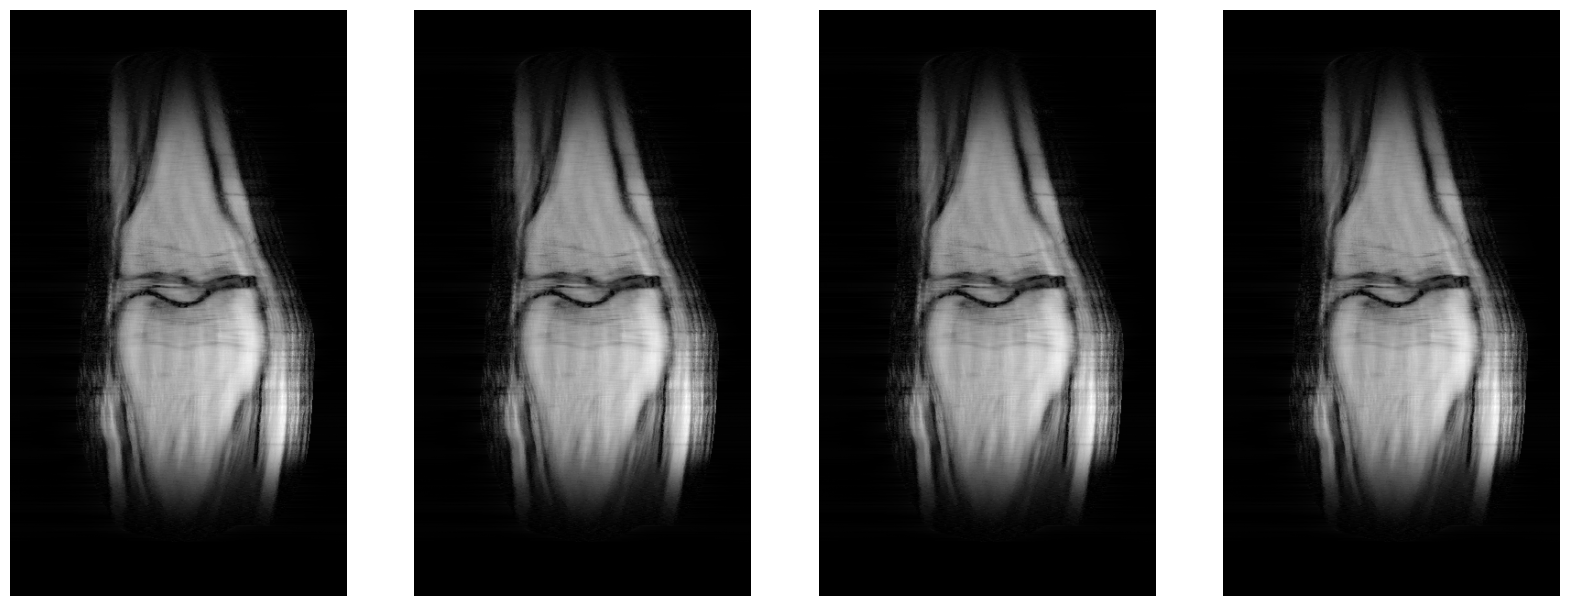

In [5]:
import matplotlib.pyplot as plt

# there are 20 images in the list,
# we want to plot them in a grid of 4x5
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
for i, image in enumerate(image_list[-4:]):
    axs[i % 5].imshow(complex_abs(image), cmap="gray")  # , vmin=0, vmax=2)
    axs[i % 5].axis("off")

# SIREN

In [6]:
from ese5934_project.models.SIREN import Siren, get_coordinates

device = torch.device("cuda:0")
size = (640, 368)
coords = get_coordinates(size)
kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
field = Siren(
    size,
    mean.to(device),
    std.to(device),
    in_features=2,
    out_features=2,
    hidden_features=256,
    hidden_layers=3,
    outermost_linear=True,
)
optimizer = torchopt.adamw(lr=1e-4)
# 1e-4 1.092077389
# 1e-3 0.08540542

/bmrc-homes/nmrgrp/nmr201/micromamba/envs/python311/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[[6.0409e-04, 7.4484e-05]]]) tensor([[[1.2870, 1.2171]]])
torch.Size([1, 1, 2]) torch.Size([1, 1, 2])
Done.


In [7]:
params, image_list = reconstruct(
    field,
    coords,
    masked_kspace,
    csm,
    mask,
    alpha=0.005,
    optimizer=optimizer,
    iterations=2000,
    device=device,
)

ic| params.keys(): dict_keys(['net.0.linear.weight', 'net.0.linear.bias', 'net.1.linear.weight', 'net.1.linear.bias', 'net.2.linear.weight', 'net.2.linear.bias', 'net.3.linear.weight', 'net.3.linear.bias', 'net.4.weight', 'net.4.bias'])


iteration 1, dc_loss: 2.969264507293701, tv_loss: 0.00025389244547113776
iteration 2, dc_loss: 2.8692243099212646, tv_loss: 0.0011568466434255242
iteration 3, dc_loss: 2.8024401664733887, tv_loss: 0.0022580393124371767
iteration 4, dc_loss: 2.7570440769195557, tv_loss: 0.0030878926627337933
iteration 5, dc_loss: 2.7259409427642822, tv_loss: 0.0036650586407631636
iteration 6, dc_loss: 2.704249858856201, tv_loss: 0.004014718346297741
iteration 7, dc_loss: 2.6870296001434326, tv_loss: 0.0042099677957594395
iteration 8, dc_loss: 2.6717581748962402, tv_loss: 0.004338923376053572
iteration 9, dc_loss: 2.6567587852478027, tv_loss: 0.004460284020751715
iteration 10, dc_loss: 2.6416494846343994, tv_loss: 0.004600003827363253
iteration 11, dc_loss: 2.626962661743164, tv_loss: 0.004753554239869118
iteration 12, dc_loss: 2.612110137939453, tv_loss: 0.004915294703096151
iteration 13, dc_loss: 2.597621202468872, tv_loss: 0.0050761704333126545
iteration 14, dc_loss: 2.583611249923706, tv_loss: 0.0052

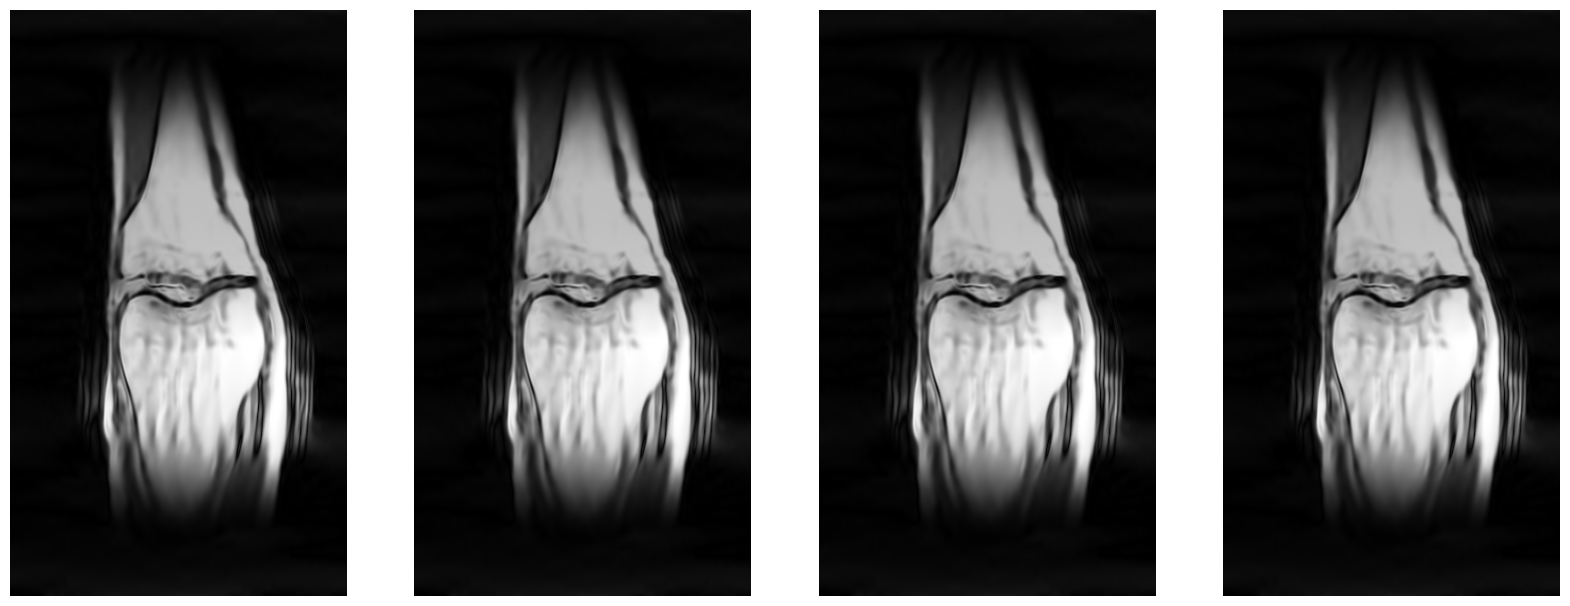

: 

In [9]:
import matplotlib.pyplot as plt

# there are 20 images in the list,
# we want to plot them in a grid of 4x5
fig, axs = plt.subplots(1, 4, figsize=(20, 10))
for i, image in enumerate(image_list[-4:]):
    axs[i % 5].imshow(complex_abs(image), cmap="gray")  # , vmin=0, vmax=2)
    axs[i % 5].axis("off")

# DictField

In [ ]:
from ese5934_project.models.SIREN import Siren, get_coordinates

device = torch.device("cuda:0")
size = (640, 368)
coords = get_coordinates(size)
kspace, (mean, std), masked_kspace, mask, csm = dataset[15]
field = Siren(
    size,
    mean.to(device),
    std.to(device),
    in_features=2,
    out_features=2,
    hidden_features=256,
    hidden_layers=3,
    outermost_linear=True,
)
optimizer = torchopt.adamw(lr=1e-4)
# 1e-4 1.092077389
# 1e-3 0.08540542

In [ ]:
params, image_list = reconstruct(
    field,
    coords,
    masked_kspace,
    csm,
    mask,
    alpha=0.005,
    optimizer=optimizer,
    iterations=2000,
    device=device,
)

In [1]:
import matplotlib.pyplot as plt
import torch

In [2]:
d = torch.load("experiments/best_case_comparision/images_dict.pt")

In [5]:
def error(gt, img):
    return (torch.view_as_complex(gt).abs() - torch.view_as_complex(img).abs()).abs()

(-0.5, 367.5, 639.5, -0.5)

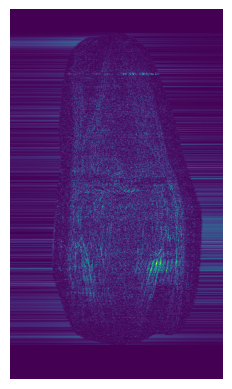

In [10]:
plt.imshow(error(d["ADAM"], d["gt"]), vmax=5)
plt.axis("off")

(-0.5, 367.5, 639.5, -0.5)

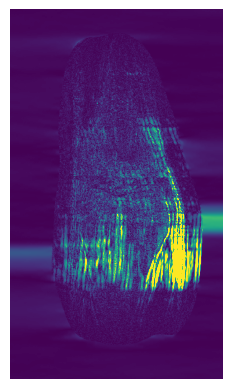

In [11]:
plt.imshow(error(d["SIREN"], d["gt"]), vmax=5)
plt.axis("off")

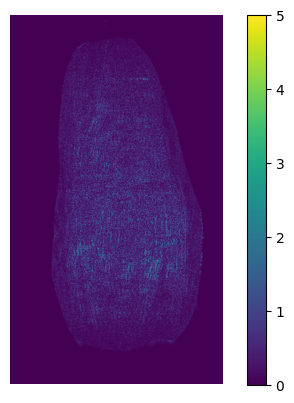

In [13]:
plt.imshow(error(d["DF"], d["gt"]), vmax=5)
plt.axis("off")
# colorbar
plt.colorbar()

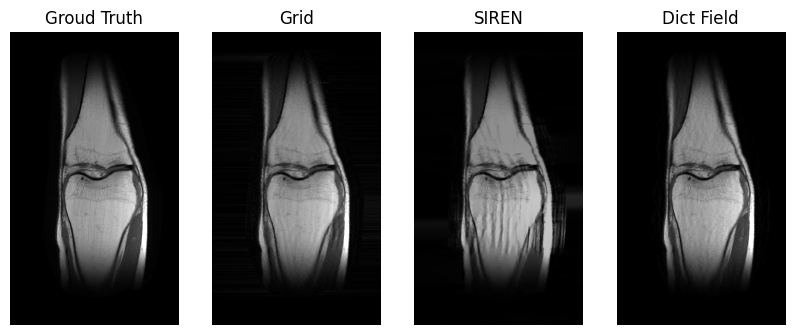

In [27]:
fig, axes = plt.subplots(1, 4, figsize=(10, 20))
for ax, im, name in zip(
    axes,
    [d["gt"], d["ADAM"], d["SIREN"], d["DF"]],
    ["Groud Truth", "Grid", "SIREN", "Dict Field"],
):
    ax.imshow(complex_abs(im), vmax=25, cmap="gray")
    ax.title.set_text(name)
    ax.axis("off")